# <span style="color:blue">Explainable AI in Natural Language Processing - LSTM Training Notebook</span>

## LSTM Keras Implementation & Training



Author: Amir Mozahebi <br>
Thesis: Evaluating Sequence Learning Models for Identifying Hate Speech using Explainable AI

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.models import Model
import keras_tuner
from keras.utils import plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import numpy as np
import seaborn as sns
import os, shutil
import gc

In [2]:
%store -r sequenceLength
%store -r vocabSize
%store -r paddedTrainSequences
%store -r trainLabels
%store -r paddedTestSequences
%store -r testLabels
%store -r tokenizer

In [3]:
print("Sequence Length: " + str(sequenceLength))
print("Vocab Size: " + str(vocabSize))
print(trainLabels[:5])

Sequence Length: 25
Vocab Size: 28829
23943    1
15123    1
4213     2
18820    1
6261     2
Name: label, dtype: int64


In [4]:
len(paddedTestSequences)

10796

In [3]:
trainLabels = tf.keras.utils.to_categorical(trainLabels, num_classes=3)
testLabels_backup = testLabels
testLabels = tf.keras.utils.to_categorical(testLabels, num_classes=3)

In [4]:
trainLabels[0]

array([0., 1., 0.], dtype=float32)

In [5]:
#Define function to plot the history of the model training (accuracy + loss)
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  

In [6]:
def plotConfusionMatrix(cm):
    group_counts = ["{0:0.0f}".format(value) for value in
                    cm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                         cm.flatten()/np.sum(cm)]

    labels = [f"{v1}\n{v2}\n" for v1, v2 in
              zip(group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(3,3)

    ax = sns.heatmap(cm, annot=labels, fmt="",cmap='Blues')

    ax.set_title('Confusion Matrix \n\n');
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values \n');

    ## Ticket labels - List must be in alphabetical order
    ax.xaxis.set_ticklabels(['Hatespeech','Offensive', 'Neither'])
    ax.yaxis.set_ticklabels(['Hatespeech','Offensive', 'Neither'])

    ## Display the visualization of the Confusion Matrix.
    plt.show()

## LSTM Model Tuning - Using Keras Tuner to optimize hyperparameters

In [7]:
# Callback to use garbage collector after each epoch to improve memory usage
class GCCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        gc.collect()

In [8]:
class MyHyperModel(keras_tuner.HyperModel):
    def build(self, hp):
        model = keras.models.Sequential()
        model.add(layers.Embedding(vocabSize, output_dim=hp.Int("output_dim", min_value=32, max_value=512, step=16), input_length=sequenceLength))
        model.add(layers.LSTM(units=hp.Int("units_lstm", min_value=32, max_value=512, step=16)))
        if hp.Boolean("dropout"):
            model.add(layers.Dropout(rate=hp.Float("dropout_rate", min_value=0.1, max_value=0.5)))
        model.add(layers.Dense(3,activation="sigmoid"))
        model.compile(
            optimizer=keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
            loss='binary_crossentropy',
            metrics=["accuracy"],
        )
        return model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [32, 64, 128]),
            **kwargs,
        )

In [9]:
# Define model hyperparameters before tuning
def buildModel(hp):
    model = keras.models.Sequential()
    model.add(layers.Embedding(vocabSize, output_dim=hp.Int("output_dim", min_value=32, max_value=512, step=16), input_length=sequenceLength))
    model.add(layers.LSTM(units=hp.Int("units_lstm", min_value=32, max_value=512, step=16)))
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=hp.Float("rate", min_value=0.1, max_value=0.5)))
    model.add(layers.Dense(3,activation="sigmoid"))
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")),
        loss='binary_crossentropy',
        metrics=["accuracy"],
    )
    return model
        

In [10]:
# Method to delete files in log directory
def cleanLogs(path):
    folder = path
    for filename in os.listdir(folder):
        file_path = os.path.join(folder, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)
        except Exception as e:
            print('Failed to delete %s. Reason: %s' % (file_path, e))

In [11]:
def tuneModels(epoch_min, epoch_max, step, X_train, X_label, Y_train, Y_label, num_trials):
    
    tuners = []
    best_model_by_epoch = []
    counter=0
    
    for i in range(epoch_min, epoch_max, step):
        counter += 1
        logPath = "training_logs/lstm_logs/tb_logs_lstm_tuner_" + str(counter)
        cleanLogs(logPath)
        tuner = keras_tuner.BayesianOptimization(
        MyHyperModel(),
        objective='val_accuracy',
        max_trials=num_trials,
        overwrite = True,
        directory='../tuner_dir/lstm_tuner_' + str(counter))
        buildModel(keras_tuner.HyperParameters())
        tuner.search(X_train, X_label, epochs=i, validation_data=(Y_train, Y_label),
        callbacks=[My,keras.callbacks.TensorBoard(logPath)])
        tuners.append(tuner)
        
    for tuner in tuners:
        model = tuner.get_best_models(num_models=1)
        best_model_by_epoch.append(model[0])
            
    return tuners, best_model_by_epoch

In [12]:
#tuners, best_models = tuneModels(10,31,10,paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5)

In [14]:
def tuneModelByEpoch(epochs, X_train, X_label, Y_train, Y_label, num_trials, logPathCounter):
     
    logPath = "training_logs/lstm_logs/tb_logs_lstm_tuner_" + str(logPathCounter)
    cleanLogs(logPath)
        
    tuner = keras_tuner.BayesianOptimization(
    MyHyperModel(),
    objective='val_accuracy',
    max_trials=num_trials,
    overwrite = True,
    directory='../tuner_dir/lstm_tuner_' + str(logPathCounter))
    
    with tf.device('/GPU:0'):
        tuner.search(X_train, X_label, epochs=epochs, validation_data=(paddedTestSequences, testLabels), verbose = 0,
        callbacks=[GCCallback(),keras.callbacks.TensorBoard(logPath)])     
  
    best_model_by_epoch = tuner.get_best_models(num_models=1)[0]
           
    return tuner, best_model_by_epoch

### Best Model for 10 epochs of training

In [15]:
tuner_1, best_model_1 = tuneModelByEpoch(10, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 1)

2022-11-17 12:58:21.164624: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-17 12:58:21.164822: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro


2022-11-17 12:58:21.518574: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-17 12:58:21.920393: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 12:58:22.050002: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 12:58:22.195055: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 12:58:51.447255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 12:58:51.492367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 13:03:25.344567: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113

INFO:tensorflow:Oracle triggered exit


In [16]:
tuner_1.results_summary()

Results summary
Results in ../tuner_dir/lstm_tuner_1/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 256
units_lstm: 96
dropout: True
lr: 0.0027125012322079677
dropout_rate: 0.39662461934382576
batch_size: 128
Score: 0.8517043590545654
Trial summary
Hyperparameters:
output_dim: 288
units_lstm: 224
dropout: True
lr: 0.0015041993987227917
dropout_rate: 0.2
batch_size: 32
Score: 0.8500370383262634
Trial summary
Hyperparameters:
output_dim: 320
units_lstm: 48
dropout: True
lr: 0.00018739248626067684
dropout_rate: 0.2783288133872382
batch_size: 64
Score: 0.8476287722587585
Trial summary
Hyperparameters:
output_dim: 352
units_lstm: 96
dropout: False
lr: 0.00020253845754746594
dropout_rate: 0.46133812869845314
batch_size: 32
Score: 0.8457762002944946
Trial summary
Hyperparameters:
output_dim: 336
units_lstm: 352
dropout: True
lr: 0.00012020752624691869
dropout_rate: 0.20370344140578459
batch_size: 32
Score: 0.8

In [17]:
best_model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 256)           7380224   
                                                                 
 lstm (LSTM)                 (None, 96)                135552    
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense (Dense)               (None, 3)                 291       
                                                                 
Total params: 7,516,067
Trainable params: 7,516,067
Non-trainable params: 0
_________________________________________________________________


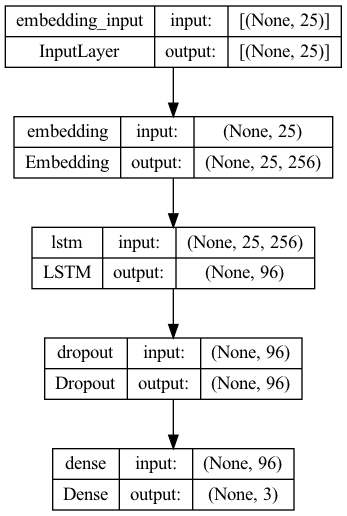

In [18]:
tf.keras.utils.plot_model(best_model_1, to_file='../plots/model_plots/lstm_model_1.png', show_shapes=True)

In [19]:
y_pred = best_model_1.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

  7/338 [..............................] - ETA: 2s  

2022-11-17 13:37:10.957124: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-17 13:37:11.001292: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 2s 5ms/step


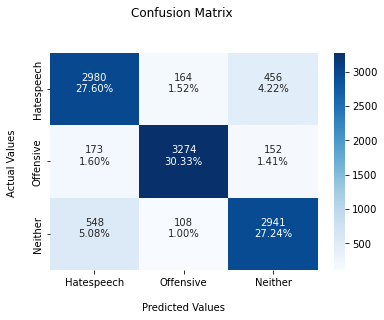

In [20]:
plotConfusionMatrix(cm)

In [21]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.81      0.83      0.82      3600
           1       0.92      0.91      0.92      3599
           2       0.83      0.82      0.82      3597

    accuracy                           0.85     10796
   macro avg       0.85      0.85      0.85     10796
weighted avg       0.85      0.85      0.85     10796



In [22]:
best_model_1.save('../models/lstm_models/lstm_model_1')

INFO:tensorflow:Assets written to: ../models/lstm_models/lstm_model_1/assets


INFO:tensorflow:Assets written to: ../models/lstm_models/lstm_model_1/assets


### Best Model for 20 epochs of training

In [23]:
tuner_2, best_model_2 = tuneModelByEpoch(20, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 2)

2022-11-16 18:24:37.626529: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 18:24:37.774458: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 18:24:38.002004: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 18:25:04.153049: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 18:25:04.207982: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 18:33:04.137963: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 18:33:04.270883: I tensorflow/core/grappler/optimizers/cust

INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [24]:
tuner_2.results_summary()

Results summary
Results in ../tuner_dir/lstm_tuner_2/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 352
units_lstm: 208
dropout: False
lr: 0.0030407211642818946
dropout_rate: 0.2684736992494745
batch_size: 128
Score: 0.8529084920883179
Trial summary
Hyperparameters:
output_dim: 144
units_lstm: 144
dropout: True
lr: 0.0032729095486270484
dropout_rate: 0.2
batch_size: 32
Score: 0.8502222895622253
Trial summary
Hyperparameters:
output_dim: 240
units_lstm: 64
dropout: True
lr: 0.005488969469040213
dropout_rate: 0.41601200448724274
batch_size: 32
Score: 0.8451278209686279
Trial summary
Hyperparameters:
output_dim: 400
units_lstm: 192
dropout: False
lr: 0.008250134756753088
dropout_rate: 0.43676752364118915
batch_size: 128
Score: 0.8437384366989136
Trial summary
Hyperparameters:
output_dim: 464
units_lstm: 160
dropout: False
lr: 0.00018924314686241615
dropout_rate: 0.40779397205375156
batch_size: 64
Score: 0.

In [25]:
best_model_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 352)           10147808  
                                                                 
 lstm (LSTM)                 (None, 208)               466752    
                                                                 
 dense (Dense)               (None, 3)                 627       
                                                                 
Total params: 10,615,187
Trainable params: 10,615,187
Non-trainable params: 0
_________________________________________________________________


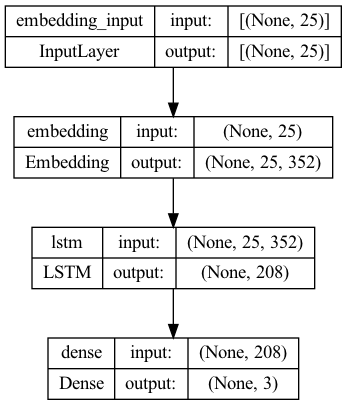

In [26]:
tf.keras.utils.plot_model(best_model_2, to_file='../plots/model_plots/lstm_model_2.png', show_shapes=True)

In [27]:
y_pred = best_model_2.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

2022-11-16 19:13:24.213151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 19:13:24.334970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 3s 6ms/step


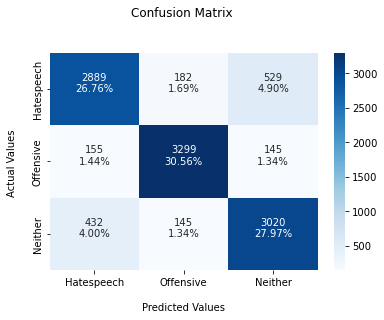

In [28]:
plotConfusionMatrix(cm)

In [29]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.83      0.80      0.82      3600
           1       0.91      0.92      0.91      3599
           2       0.82      0.84      0.83      3597

    accuracy                           0.85     10796
   macro avg       0.85      0.85      0.85     10796
weighted avg       0.85      0.85      0.85     10796



In [30]:
best_model_2.save('../models/lstm_models/lstm_model_2')

INFO:tensorflow:Assets written to: ../models/lstm_models/lstm_model_2/assets


INFO:tensorflow:Assets written to: ../models/lstm_models/lstm_model_2/assets


### Best Model for 30 epochs of training

In [16]:
tuner_3, best_model_3 = tuneModelByEpoch(30, paddedTrainSequences, trainLabels, paddedTestSequences, testLabels, 5, 3)

2022-11-16 20:55:57.220159: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 20:55:57.341295: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 20:55:57.451795: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 20:56:20.975727: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 20:56:21.026075: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 21:08:09.366888: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 21:08:09.490893: I tensorflow/core/grappler/optimizers/cust

INFO:tensorflow:Oracle triggered exit


In [17]:
tuner_3.results_summary()

Results summary
Results in ../tuner_dir/lstm_tuner_3/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
output_dim: 80
units_lstm: 176
dropout: True
lr: 0.0013908860156872532
dropout_rate: 0.47786661400158215
batch_size: 32
Score: 0.8467024564743042
Trial summary
Hyperparameters:
output_dim: 112
units_lstm: 384
dropout: True
lr: 0.0004321822819022588
dropout_rate: 0.2
batch_size: 32
Score: 0.8422563672065735
Trial summary
Hyperparameters:
output_dim: 128
units_lstm: 432
dropout: True
lr: 0.00045072104393307306
dropout_rate: 0.498473807606187
batch_size: 32
Score: 0.8419784903526306
Trial summary
Hyperparameters:
output_dim: 176
units_lstm: 400
dropout: False
lr: 0.0008212513916942193
dropout_rate: 0.45320271061141504
batch_size: 128
Score: 0.8396628499031067
Trial summary
Hyperparameters:
output_dim: 400
units_lstm: 240
dropout: True
lr: 0.00015084220262331162
dropout_rate: 0.34544228153192463
batch_size: 32
Score: 0.8

In [18]:
best_model_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 25, 80)            2306320   
                                                                 
 lstm (LSTM)                 (None, 176)               180928    
                                                                 
 dropout (Dropout)           (None, 176)               0         
                                                                 
 dense (Dense)               (None, 3)                 531       
                                                                 
Total params: 2,487,779
Trainable params: 2,487,779
Non-trainable params: 0
_________________________________________________________________


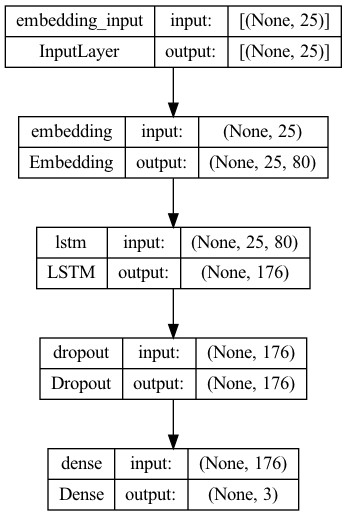

In [19]:
tf.keras.utils.plot_model(best_model_3, to_file='../plots/model_plots/lstm_model_3.png', show_shapes=True)

In [20]:
y_pred = best_model_3.predict(paddedTestSequences)
cm = confusion_matrix(testLabels.argmax(axis=1), y_pred.argmax(axis=1))
test_predictions = np.argmax(y_pred, axis=-1)

  9/338 [..............................] - ETA: 2s  

2022-11-16 21:58:26.228312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-11-16 21:58:26.273549: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


338/338 [==============================] - 2s 5ms/step


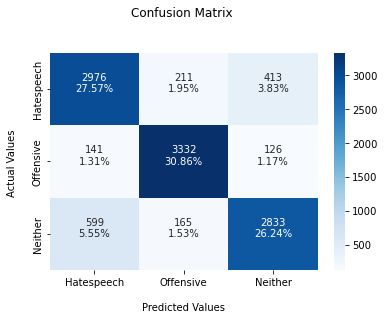

In [21]:
plotConfusionMatrix(cm)

In [22]:
print(classification_report(testLabels_backup, test_predictions))

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      3600
           1       0.90      0.93      0.91      3599
           2       0.84      0.79      0.81      3597

    accuracy                           0.85     10796
   macro avg       0.85      0.85      0.85     10796
weighted avg       0.85      0.85      0.85     10796



In [23]:
best_model_3.save('../models/lstm_models/lstm_model_3')

INFO:tensorflow:Assets written to: ../models/lstm_models/lstm_model_3/assets


INFO:tensorflow:Assets written to: ../models/lstm_models/lstm_model_3/assets
